# 1. DataLoader

In [ ]:
# Computing image statistics so that 
# we can normalize the dataset in the future

# first create a data loader for the dataset 
# which is used to calculate image statistics
import os 
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class SimpleImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.tranform = transform
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self):
        
        # import
        path = os.path.join(self.img_dir, self.data.iloc)

In [45]:
# use ImageFolder to create a data loader
# PyTorch use PIL to read in image and the brightness is in 0~1
# Note: there is no normalization in this process
# My idea is first use this data loader to load all the image
# Then calsulate the mean and std
# Then create another data loader and include normalization process

import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='./train_1k',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=1, shuffle=True)



In [50]:
img, label = next(iter(dataset_loader))
img = img[0].squeeze()
img.shape

torch.Size([3, 256, 256])

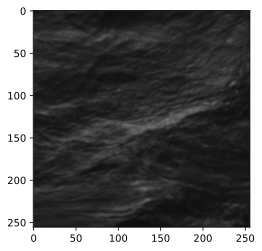

In [54]:
import matplotlib.pyplot as plt
plt.imshow(img.numpy().transpose((1, 2, 0)))

In [21]:
from tqdm import tqdm
# placeholders
psum    = torch.tensor([0.0])
psum_sq = torch.tensor([0.0])

for imgs in tqdm(dataset_loader):
    psum += imgs[0].sum()
    psum_sq += (imgs[0] ** 2).sum()

100%|██████████| 9024/9024 [00:47<00:00, 191.01it/s]


In [22]:
count = 9024 * 256 * 256
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

In [23]:
total_mean

tensor([0.3374])

In [24]:
total_std

tensor([0.1843])

In [55]:
data_transform = transforms.Compose([
        transforms.Resize(256), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3374,0.3374,0.3374],
                             std=[0.1843,0.1843,0.1843])
    ])
train_dataset = datasets.ImageFolder(root='./train_1k',
                                           transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=64, shuffle=True)

In [27]:
img, label = next(iter(dataset_loader))
img = img[0].squeeze()
img.shape

torch.Size([256, 256])

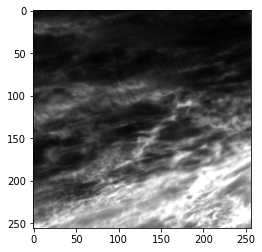

In [28]:
plt.imshow(img, cmap="gray")

In [63]:
# dataloader for test
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3374,0.3374,0.3374],
                             std=[0.1843,0.1843,0.1843])
    ])
test_dataset = datasets.ImageFolder(root='./test',
                                           transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=64, shuffle=True)

# 2. Training

Without Validation

In [64]:
class Accumulator:
    """Accumulate on variables"""
    def __init__(self, n):
        self.data = [0.0] * n
        
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [65]:
from IPython import display

def use_svg_display():
    """使用svg格式在Jupyter中显示绘图"""
    display.set_matplotlib_formats('svg')
    
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [70]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [67]:
def evaluate_accuracy_gpu(model, data_iter, device=None): 
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(model, nn.Module):
        model.eval()  # 设置为评估模式
        if not device:
            device = next(iter(model.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(model(X), y), y.numel())
    return metric[0] / metric[1]

In [92]:
# function for training the model
from torch.optim import lr_scheduler
# torch.optim.lr_scheduler provides methods to adjust the learning rate
# based on the number of epochs. 
from torchvision import models
import time
import copy

train_data_size = len(train_dataset)
test_data_size = len(test_dataset)

def train_model(model, device, train_loader, test_loader,
                train_data_size, criterion, optimizer, 
                num_epochs = 4):
    since = time.time() # time when this part starts running
    
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)
        
        model.train() # Set model to training mode
        
        running_loss = 0.0
        running_corrests = 0
        
        metric = Accumulator(3)
        
        
        # Iterate over data. 
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # backward + optimize
            loss.backward()
            optimizer.step()
            
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrests += torch.sum(preds == labels.data)
            
            with torch.no_grad():
                  metric.add(loss * inputs.shape[0],
                             accuracy(preds, labels), 
                             inputs.shape[0])
                  
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            animator.add(epoch + (i + 1) / len(train_loader),
                            (train_l, train_acc, None))
            
        epoch_loss = running_loss / train_data_size
        epoch_acc = running_corrests.double() / train_data_size
        test_acc = evaluate_accuracy_gpu(model, test_loader)
        
        print(f'Train Loss: {epoch_loss:.4f}, Train acc: {epoch_acc:.4f}, '
              f'Test acc {test_acc:.4f}')
        animator.add(epoch + 1, (None, None, test_acc))
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m '
          f'{time_elapsed % 60:.0f}s '
          f' on {str(device)}')
    return model        

In [83]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)



Training complete in 6m 5s  on cuda:0


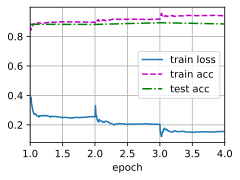

In [93]:
model_ft = train_model(model_ft, device, train_loader, test_loader, 
                       train_data_size, criterion, optimizer_ft,
                       num_epochs=4)

In [77]:
import numpy as np
class_names = train_dataset.classes
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

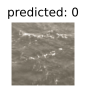

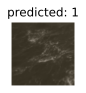

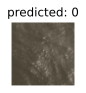

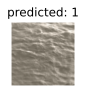

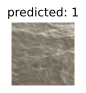

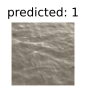

In [78]:
visualize_model(model_ft)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')